In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from urllib.parse import unquote
import numpy as np
import os
import seaborn as sns
import networkx as nx

from src.preprocessing import WikispeediaData
from src.analysis_helpers import *
from src.plot_functions import *

### Reading data
Reading data and preprocessing it in WikispeediaData class

In [ ]:
#Takes some time to run!
data = WikispeediaData()

data.count_articles()

In [ ]:
data.articles.sort_values(by="nb_in_finished_paths", ascending=False).head(1)

,article_name,nb_in_unfinished_paths,nb_in_finished_paths,nb_links
4297,United States,3161,8482,3321


In [ ]:
data.links.head(1)

,1st article,2nd article,different_cat
0,Áedán mac Gabráin,Bede,0.0


### Analysing cases where target cannot be reached from the source in shortest path matrix
These values where set to nan in the preprocessing instead of "_"

In [ ]:
n_rows, n_cols = np.shape(data.matrix)

#Counting nan values for each row
nan_counts_per_row = np.sum(np.isnan(data.matrix), axis=1)

#Getting unique nan counts and how many times they occur
unique_counts, counts = np.unique(nan_counts_per_row, return_counts=True)

print('Number of rows', n_rows)

print("Number of NaN counts and their frequencies:")
for value, count in zip(unique_counts, counts):
    print(f"{value} NaN values: {count} occurrences")

Number of rows 4604
Number of NaN counts and their frequencies:
543 NaN values: 6 occurrences
545 NaN values: 1 occurrences
546 NaN values: 9 occurrences
547 NaN values: 57 occurrences
548 NaN values: 461 occurrences
549 NaN values: 4051 occurrences
4601 NaN values: 1 occurrences
4602 NaN values: 1 occurrences
4603 NaN values: 17 occurrences


From this we can see that there are 17 articles which are not connected to any other article i.e. from them you cannot navigate to any other article. Two articles which are only connected to 1 or 2 other articles and not connected to the rest of the network. They are included in paths and for now we have decided to keep them in the dataset.

In [ ]:
#Printing article names with high number of nan values
indices = np.where(nan_counts_per_row > 4600)[0]
article_names = data.articles.iloc[indices]

article_names


,article_name,nb_in_unfinished_paths,nb_in_finished_paths,nb_links
441,Badugi,0,0,0
970,Color Graphics Adapter,0,0,0
1210,Directdebit,0,0,6
1231,Donation,0,0,0
1237,Douglas DC-4,0,0,0
1257,Duchenne muscular dystrophy,0,0,1
1600,Friend Directdebit,0,0,2
2351,Klinefelter's syndrome,0,0,1
2530,Local community,1,0,1
2543,Lone Wolf (gamebooks),0,0,0


### Creating dataframe from data to analyse Hubs
Contains number of articles to a given article and number of articles from a given article. Mean shortest path to it and from it.

In [ ]:
df_hubs = pd.DataFrame()
df_hubs["article_names"] = data.articles["article_name"]

#Printing wikipages with most links
source_counts = data.links['1st article'].value_counts()
df_hubs["source_counts"] = df_hubs["article_names"].map(source_counts).fillna(0).astype(int)

target_counts = data.links['2nd article'].value_counts()
df_hubs["target_counts"] = df_hubs["article_names"].map(target_counts).fillna(0).astype(int)

df_hubs["mean_shortest_path_to_article"] = np.nanmean(data.matrix, axis = 0)
df_hubs["mean_shortest_path"] = np.nanmean(data.matrix, axis = 1)

In [ ]:
df_hubs.describe() 

,source_counts,target_counts,mean_shortest_path_to_article,mean_shortest_path
count,4604.000000,4604.000000,4604.000000,4604.000000
mean,26.038662,26.038662,2.829412,3.188769
std,24.201491,62.746827,1.170888,0.321702
min,0.000000,0.000000,0.000000,0.000000
25%,11.000000,2.000000,2.626172,3.025154
50%,19.000000,8.000000,2.989640,3.179408
75%,33.000000,25.000000,3.476390,3.344081
max,294.000000,1551.000000,6.866085,5.119852


In [ ]:
#Adding categories to hubs dataframe
categories = np.unique(data.categories['1st cat'])
# Add a column for each category in categories_ha
for category in categories:
    articles_in_category = data.categories.loc[data.categories['1st cat'] == category, 'article_name']
    df_hubs[category] = np.where(df_hubs['article_names'].isin(articles_in_category), 1, 0)

In [ ]:
df_hubs.head()

,article_names,source_counts,target_counts,mean_shortest_path_to_article,mean_shortest_path,Art,Business Studies,Citizenship,Countries,Design and Technology,Everyday life,Geography,History,IT,Language and literature,Mathematics,Music,People,Religion,Science
0,Áedán mac Gabráin,11,0,0.0,3.395464,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,Åland,19,0,0.0,3.127959,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
2,Édouard Manet,20,0,0.0,3.171598,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Éire,8,0,0.0,3.325937,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
4,Óengus I of the Picts,10,0,0.0,3.386834,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


### Plotting distributions 
Plotting distributions of number of links in articles, number of links to articles, categories, mean shortest path distance from articles, mean shorest distance to article. 

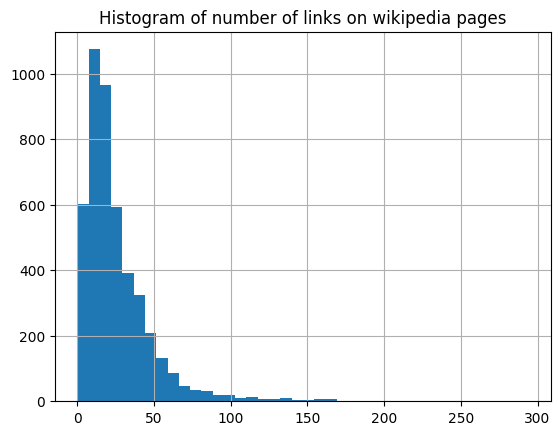

In [ ]:
#Plotting distribution of links on wikipages
df_hubs.hist(column = "source_counts", bins = 40)
plt.title('Histogram of number of links on wikipedia pages')
plt.show()

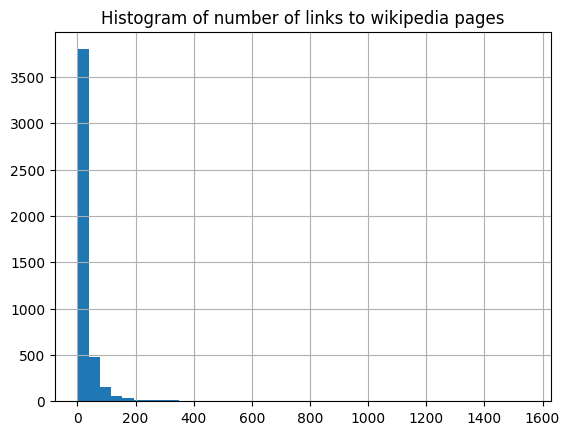

In [ ]:
#Plotting distribution of links to wikipages
df_hubs.hist(column = "target_counts", bins = 40)
plt.title('Histogram of number of links to wikipedia pages')
plt.show()

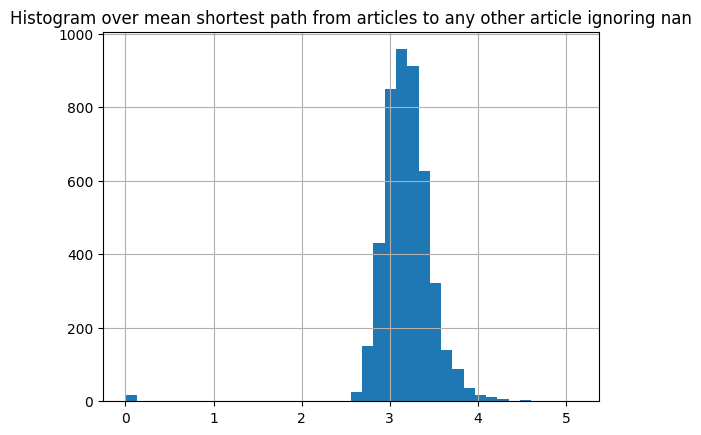

In [ ]:
df_hubs.hist(column = "mean_shortest_path", bins = 40)
plt.title('Histogram over mean shortest path from articles to any other article ignoring nan')
plt.show()

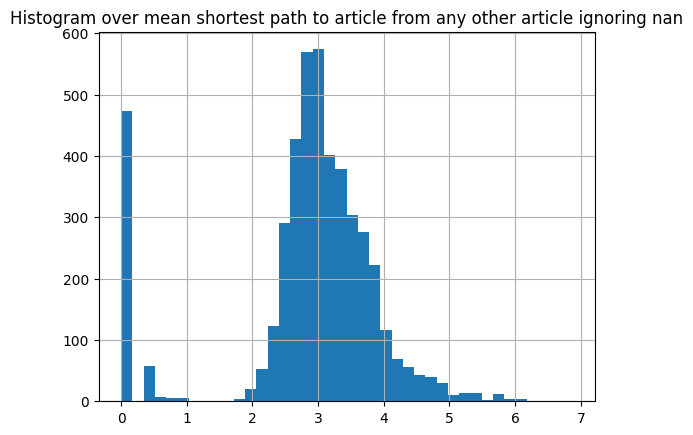

In [ ]:
df_hubs.hist(column = "mean_shortest_path_to_article", bins = 40)
plt.title('Histogram over mean shortest path to article from any other article ignoring nan')
plt.show()

### Looking at some extreme values

In [ ]:
#Looking at values which have mean shortest path 0
min_value = df_hubs["mean_shortest_path"].min()

min_indices = df_hubs["article_names"].index[df_hubs["mean_shortest_path"] == min_value].tolist()

print('Articles with min distance', min_value)
df_hubs["article_names"].iloc[min_indices]

Articles with min distance 0.0


441                                                Badugi
970                                Color Graphics Adapter
1210                                          Directdebit
1231                                             Donation
1237                                         Douglas DC-4
1257                          Duchenne muscular dystrophy
2351                               Klinefelter's syndrome
2530                                      Local community
2543                                Lone Wolf (gamebooks)
3108                                         Osteomalacia
3352                                     Private Peaceful
3645                                        Schatzki ring
3928                                          Suikinkutsu
4289                                Underground (stories)
4333                                           Vacutainer
4480    Wikipedia Text of the GNU Free Documentation L...
4545                                          Wowpurchase
Name: article_

### Some basic plots exploring the data 

In [ ]:
df_hubs.head()

,article_names,source_counts,target_counts,mean_shortest_path_to_article,mean_shortest_path,Art,Business Studies,Citizenship,Countries,Design and Technology,Everyday life,Geography,History,IT,Language and literature,Mathematics,Music,People,Religion,Science
0,Áedán mac Gabráin,11,0,0.0,3.395464,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,Åland,19,0,0.0,3.127959,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
2,Édouard Manet,20,0,0.0,3.171598,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Éire,8,0,0.0,3.325937,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
4,Óengus I of the Picts,10,0,0.0,3.386834,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


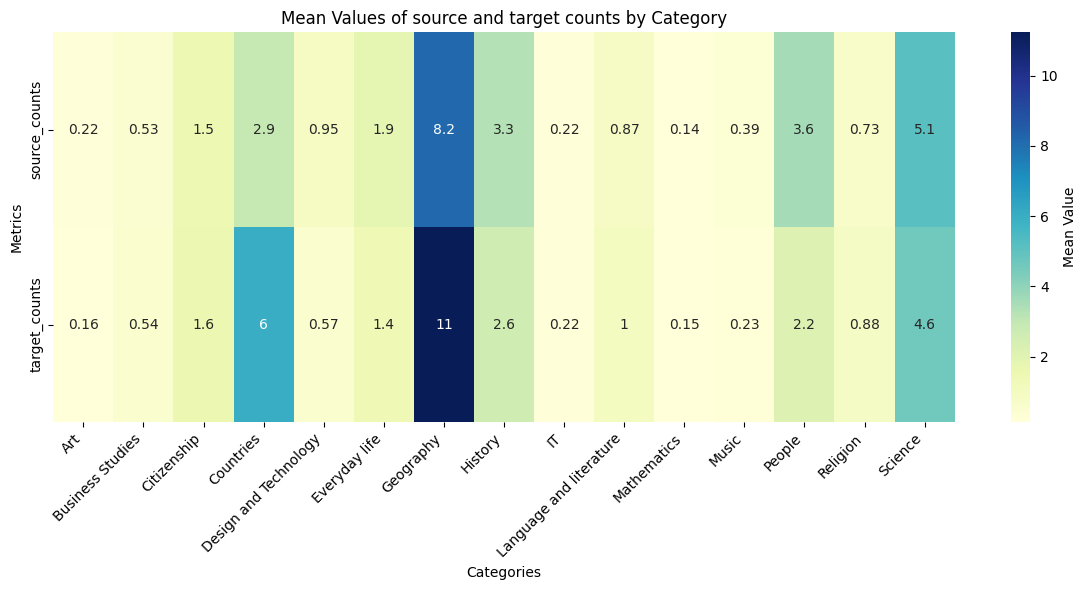

In [ ]:

mean_values = df_hubs[["source_counts", "target_counts"]].mean()
categories = df_hubs.columns[5:]

# Create matrix for plotting
matrix = pd.DataFrame({
    "source_counts": df_hubs[categories].multiply(df_hubs["source_counts"], axis=0).mean(),
    "target_counts": df_hubs[categories].multiply(df_hubs["target_counts"], axis=0).mean()}).T

# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(matrix, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Mean Value'})
plt.title('Mean Values of source and target counts by Category')
plt.xlabel('Categories')
plt.ylabel('Metrics')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
#Looked at correlation between variables not sure if this is relevant to our analysis?
correlation_matrix = df_hubs[['source_counts','target_counts','mean_shortest_path_to_article','mean_shortest_path']].corr()

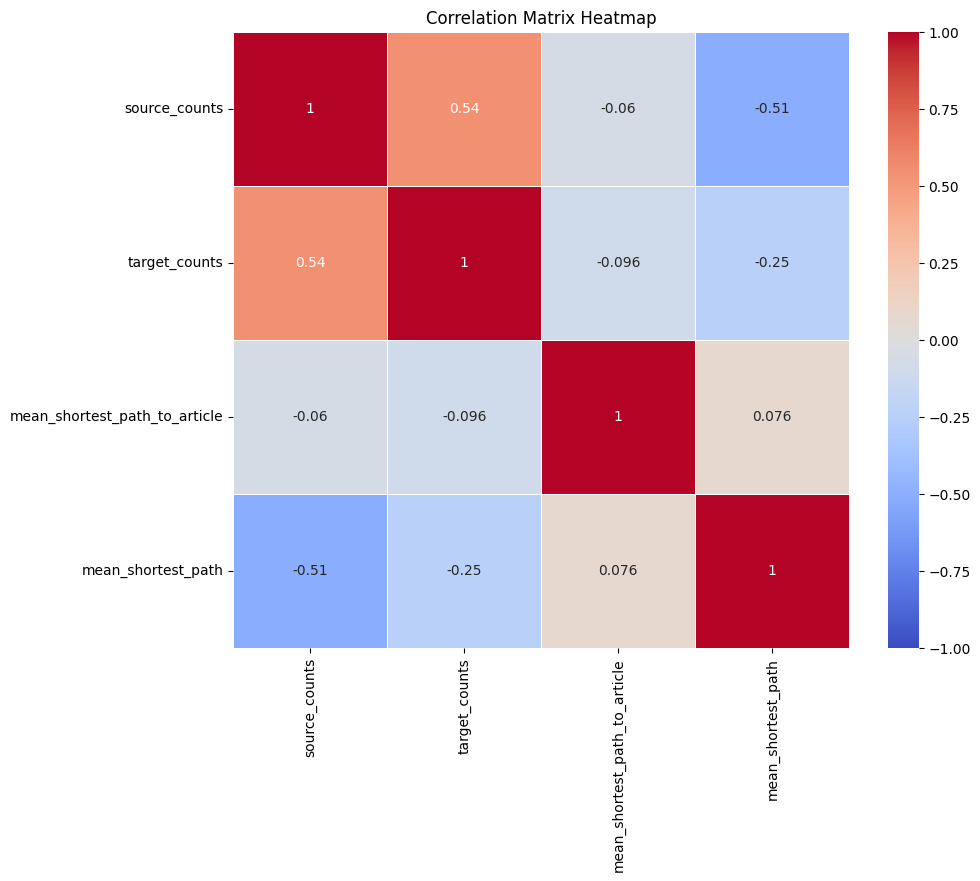

In [ ]:
plt.figure(figsize=(10, 8)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True, linewidths=0.5)

plt.title('Correlation Matrix Heatmap')
plt.show()

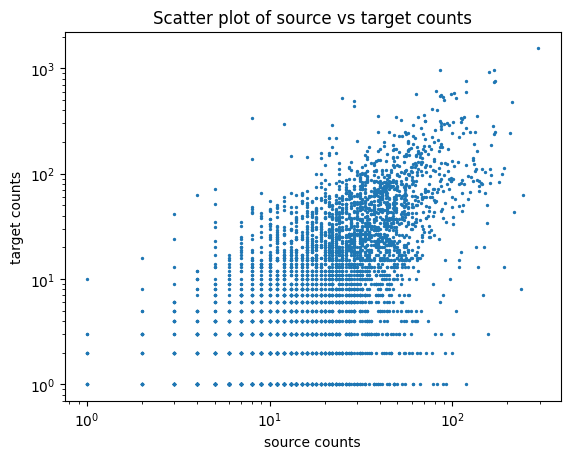

In [ ]:
plt.scatter(df_hubs['source_counts'], df_hubs['target_counts'], s=2)
plt.yscale('log')
plt.title('Scatter plot of source vs target counts')
plt.xlabel('source counts')
plt.ylabel('target counts')
plt.xscale('log')
plt.show()

### Looking at distribution of categories

How to deal with articles which are apart of more than 1 main category?

Text(0, 0.5, 'Frequency')

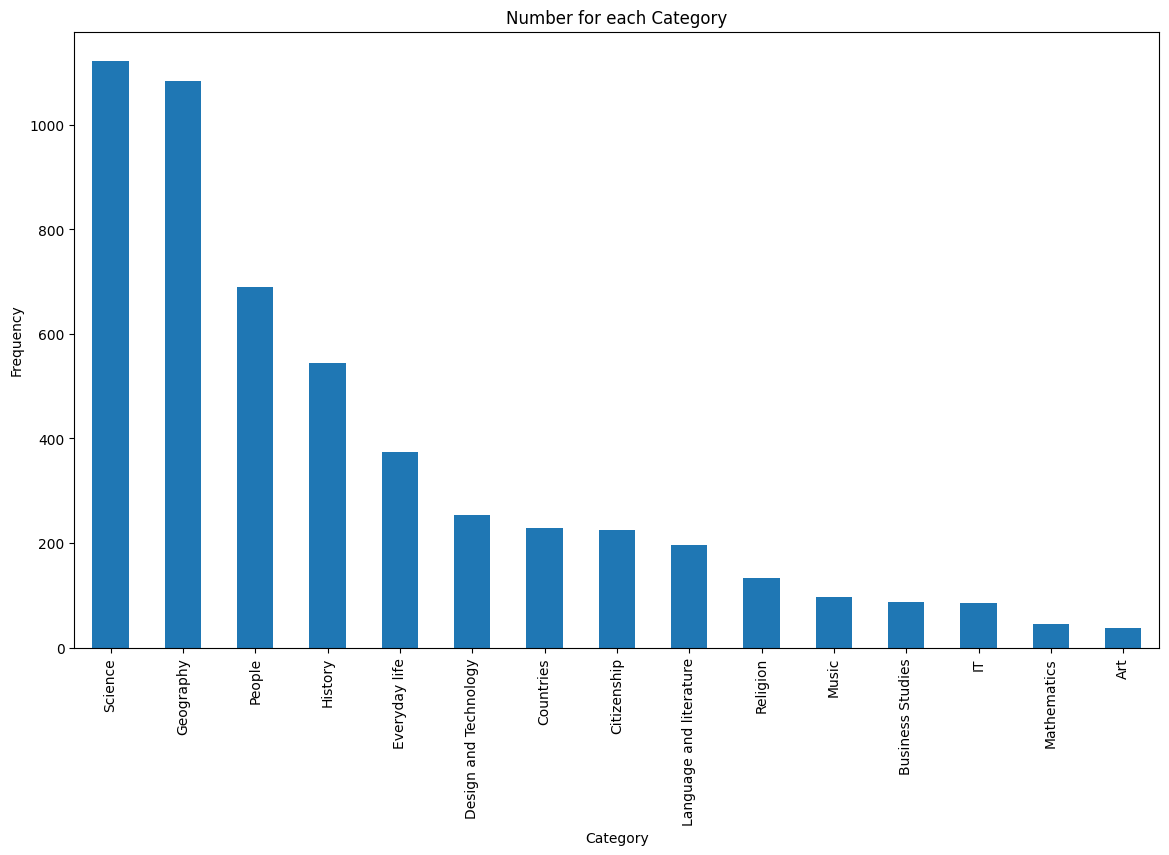

In [ ]:
ax = data.categories['1st cat'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number for each Category")
ax.set_xlabel("Category")
ax.set_ylabel("Frequency")

### Looking at the mean shortest path distance grouped by subject

### Calculate how many subjects a given article is connected to

#### Implement PageRank

In [ ]:
# Create a graph
G = nx.DiGraph()

# Add edges from the links data
edges = list(zip(data.links['1st article'], data.links['2nd article']))
G.add_edges_from(edges)

# calculate PageRank
pagerank_scores = nx.pagerank(G)

# Add PageRank scores to df_hubs
df_hubs["pagerank_score"] = df_hubs["article_names"].map(pagerank_scores).fillna(0)

# show top hubs by PageRank
columns_disp = [
    "article_names", 
    "source_counts", 
    "target_counts", 
    "mean_shortest_path_to_article", 
    "mean_shortest_path", 
    "pagerank_score"
]

# Sort and display the selected columns
top_hubs_pr = df_hubs.sort_values(by="pagerank_score", ascending=False).head(5)[columns_disp]
top_hubs_msp = df_hubs.sort_values(by="target_counts", ascending=False).head(5)[columns_disp]

# Print the results
print(top_hubs_pr)
print(top_hubs_msp)

         article_names  source_counts  target_counts  \
4297     United States            294           1551   
1568            France             85            959   
1433            Europe            159            933   
4293    United Kingdom            168            972   
1389  English language            118            598   

      mean_shortest_path_to_article  mean_shortest_path  pagerank_score  
4297                       1.690949            2.484834        0.009566  
1568                       1.849291            2.780518        0.006423  
1433                       1.839258            2.648335        0.006340  
4293                       1.843621            2.606165        0.006235  
1389                       1.945038            2.746239        0.004865  
       article_names  source_counts  target_counts  \
4297   United States            294           1551   
4293  United Kingdom            168            972   
1568          France             85            959   
143

PageRank values represent the probability that a random internet surfer will land on that node/page. So the sum of the pagerank value for all the nodes is 1. As expected, the top values are United States, France, and Europe. 

#### PageRank for hubs with outgoing links

In [ ]:
G = nx.DiGraph()

# Add edges from the 'links' data
edges = list(zip(data.links['1st article'], data.links['2nd article']))
G.add_edges_from(edges)

# Step 2: Add weights based on out-degree (number of links a node points to)
for node in G.nodes:
    G.nodes[node]['out_degree'] = G.out_degree(node)

# Step 3: Custom PageRank calculation, biased toward hubs
pagerank_scores = nx.pagerank(G, personalization={node: G.nodes[node]['out_degree'] for node in G.nodes})

# Step 4: Add the scores back to `df_hubs`
df_hubs["pagerank_hub_score"] = df_hubs["article_names"].map(pagerank_scores).fillna(0)

# Inspect the top hubs based on the new PageRank
top_hubs = df_hubs.sort_values(by="pagerank_hub_score", ascending=False).head(10)
print(top_hubs)

         article_names  source_counts  target_counts  \
4297     United States            294           1551   
1568            France             85            959   
1433            Europe            159            933   
4293    United Kingdom            168            972   
1694           Germany            169            743   
1389  English language            118            598   
4542      World War II            119            751   
1385           England            172            751   
2098             India             81            611   
2417             Latin             29            443   

      mean_shortest_path_to_article  mean_shortest_path  Art  \
4297                       1.690949            2.484834    0   
1568                       1.849291            2.780518    0   
1433                       1.839258            2.648335    0   
4293                       1.843621            2.606165    0   
1694                       1.904035            2.626880    0   